# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per month of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Summary of the approach ###

After having taken a careful look to the data, we notice that there isn't a report for each day in the 3 datasets. We also notice that each file contains cumulative value of the new cases/deaths. We will thus extrapolate the average new values per day in one month with these cumulative values; indeed, if we know the total number $x_d$ of deaths at day d and the total number of death $x_{d + n}$ at day d + n we know that there were in average $\frac{x_{d + n} - x_d}{n}$ new deaths per day during this period. We will therefore take the data the nearest of the first and the last day of the month to compute the average values. We also could have used interpolation to estimate the exact number at first and last day of the month.

Import useful libraries.

In [3]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import datetime
import matplotlib.pyplot as plt
import calendar
from calendar import monthrange
import datetime


Load the data into one dataframe. During this phase we reorganise the data and remove the samples having an unknown or 0 value for the observed data, as the cumulative values don't start at 0 for any country. We only take care of the national value as they're sufficient to estimate the country average.

In [4]:
folders = ['guinea', 'liberia', 'sl']
folder_end = '_data/'
folder_begin = 'ebola/'

type_of_file = []
name_of_file = []
counter = 0
ebola_data = pd.DataFrame(columns=['country', 'date', 'description', 'number'])
for folder in folders:
    folder_path = DATA_FOLDER + folder_begin + folder + folder_end
    print("Loading data from %s" % folder)
    for data_file in listdir(folder_path):
        counter = counter + 1
        if isfile(join(folder_path, data_file)):
            datas = pd.DataFrame.from_csv(folder_path + data_file)
            datas.columns = [col.lower() for col in datas.columns]
            
            towns = list(datas.columns[1:])
            date = datas.index.name
            description = datas.columns[0]
            total_col_name = 'totals' if 'totals' in datas.columns else 'national'
            towns.remove(total_col_name)
            
            datas = datas.reset_index().copy()
            datas['country'] = folder
            
            #Reorganise data in a uniform way
            datas = datas[['country', date, description, total_col_name]]
            datas.columns = ['country', 'date', 'description', 'number']
            
            #Transform values in integer.
            datas = datas.fillna(0)
            datas = datas[~datas['number'].astype(str).str.contains('%')]
            datas['number'] = datas['number'].astype(str).str.replace(',', '')
            datas['number'] = datas['number'].astype(float).astype(int)
            
            ebola_data = pd.concat([ebola_data, datas], axis=0)
            
print('Loading completed.')

Loading data from guinea
Loading data from liberia
Loading data from sl
Loading completed.


We transform the categories and numbers observed in separate columns, each of them containing the category name and the number observed for this category. We then aggregate using max on the groups (country, date) as we are only interested in the cumulative values.

In [5]:
ebola_data_hot_encoded = pd.get_dummies(ebola_data, columns=['description'])

for description in ebola_data_hot_encoded.columns[3:]:
    ebola_data_hot_encoded.loc[(ebola_data_hot_encoded[description] == 1), description] = \
        ebola_data_hot_encoded[ebola_data_hot_encoded[description] == 1].number

ebola_data_hot_encoded = ebola_data_hot_encoded.groupby(by=['country', 'date']).agg(np.max)
ebola_data_hot_encoded.columns = [col.lower().replace('\n', '') for col in ebola_data_hot_encoded.columns]


We now select only the categories which interest us (new cases and deaths) and create two new columns containing the cumulative number of new cases and deaths for each country and date. We choose to consider every case and death (confirmed, probable and suspected). For certain spreadsheets we need to sum over 3 columns to obtain the total number.

In [6]:
cumulative_deaths = ['description_total death/s in confirmed,  probable, suspected cases',  
                     'description_total death/s in confirmed, probable, suspected cases',
                    'description_total deaths (confirmed + probables + suspects)','cum_death_tmp']

death_to_agg = ['description_death_suspected', 'description_death_probable', 'description_death_confirmed']
ebola_data_hot_encoded['cum_death_tmp'] = np.sum(ebola_data_hot_encoded[death_to_agg].values, axis=1)

cumulative_cases = ['description_cumulative confirmed, probable and suspected cases', 
                    'description_cumulative (confirmed + probable + suspects)', 'cum_cases_tmp1', 'cum_cases_tmp2']

cases_to_agg = ['description_total suspected cases', 'description_total probable cases', 'description_total confirmed cases']
ebola_data_hot_encoded['cum_cases_tmp1'] = np.sum(ebola_data_hot_encoded[cases_to_agg].values, axis=1)

cases_to_agg = ['description_cum_confirmed', 'description_cum_probable', 'description_cum_suspected']
ebola_data_hot_encoded['cum_cases_tmp2'] = np.sum(ebola_data_hot_encoded[cases_to_agg].values, axis=1)

ebola_data_hot_encoded.columns = [col.lower().replace('\n', '') for col in ebola_data_hot_encoded.columns]
ebola_data_hot_encoded['cum_cases'] = np.max(ebola_data_hot_encoded[cumulative_cases].values, axis=1)

ebola_data_hot_encoded['cum_deaths'] = np.max(ebola_data_hot_encoded[cumulative_deaths].values, axis=1)


Then we remove the samples with values equal to zero.

In [7]:
ebola_data_hot_encoded = ebola_data_hot_encoded[(ebola_data_hot_encoded['cum_deaths'] != 0) & 
                                                (ebola_data_hot_encoded['cum_cases'] != 0)]

We plot the cumulative deaths and cases obtained for each country to observe the results.

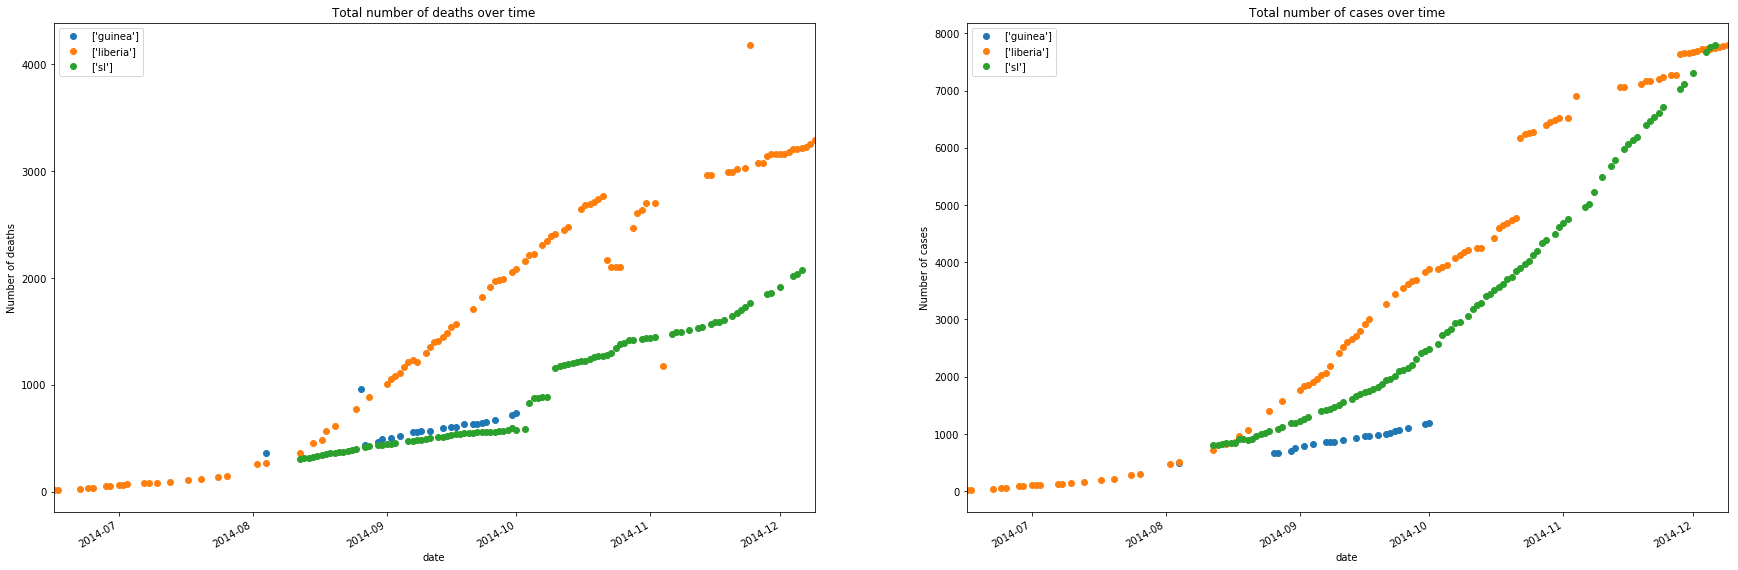

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

final_ebola_data = ebola_data_hot_encoded[['cum_deaths', 'cum_cases']].reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

tmp_df = final_ebola_data.groupby('country')

tmp_df.plot(style='o', x='date', y='cum_deaths', ax=axes[0], legend=True, title='Total number of deaths over time')
axes[0].legend(tmp_df.country.unique())
axes[0].set_ylabel('Number of deaths')

tmp_df.plot(style='o', x='date', y='cum_cases', ax=axes[1], legend=True, title='Total number of cases over time')
axes[1].legend(tmp_df.country.unique())
axes[1].set_ylabel('Number of cases')

#fig.show()

The results above make us notice some aberrant values (end of August for Guinea and end of October for Liberia) in the deaths cumulative values: these values will be removed later from the samples. Although it may look like a brutal approach, we are not able to discuss with the people who created the dataset which means that we are not able to decide perfectly which cumulative value is more reliable than the other. However, for each of these aberrant values we manually check if it's not a code error. We also check that the total amount of samples kept after all the cleaning operations is satisfying.

cum_cases                                                           \
            count         mean          std    min     25%     50%     75%   
country                                                                      
guinea       19.0   913.210526   181.067077  495.0   806.5   936.0  1035.0   
liberia      79.0  3331.936709  2653.499326   22.0   844.0  3017.0  4675.0   
sl           89.0  3260.550562  2053.308267  800.0  1478.0  2937.0  4611.0   

                cum_deaths                                                  \
            max      count         mean          std    min    25%     50%   
country                                                                      
guinea   1199.0       19.0   578.052632    96.413734  363.0  511.5   595.0   
liberia  7797.0       79.0  1633.088608  1148.796429   16.0  468.0  1567.0   
sl       7798.0       89.0   980.112360   535.273516  303.0  484.0   885.0   

                         
            75%     max  
country                  
guinea    639.0   739.0  
liberia  2701.5  3290.0  
sl       1435.0  2074.0

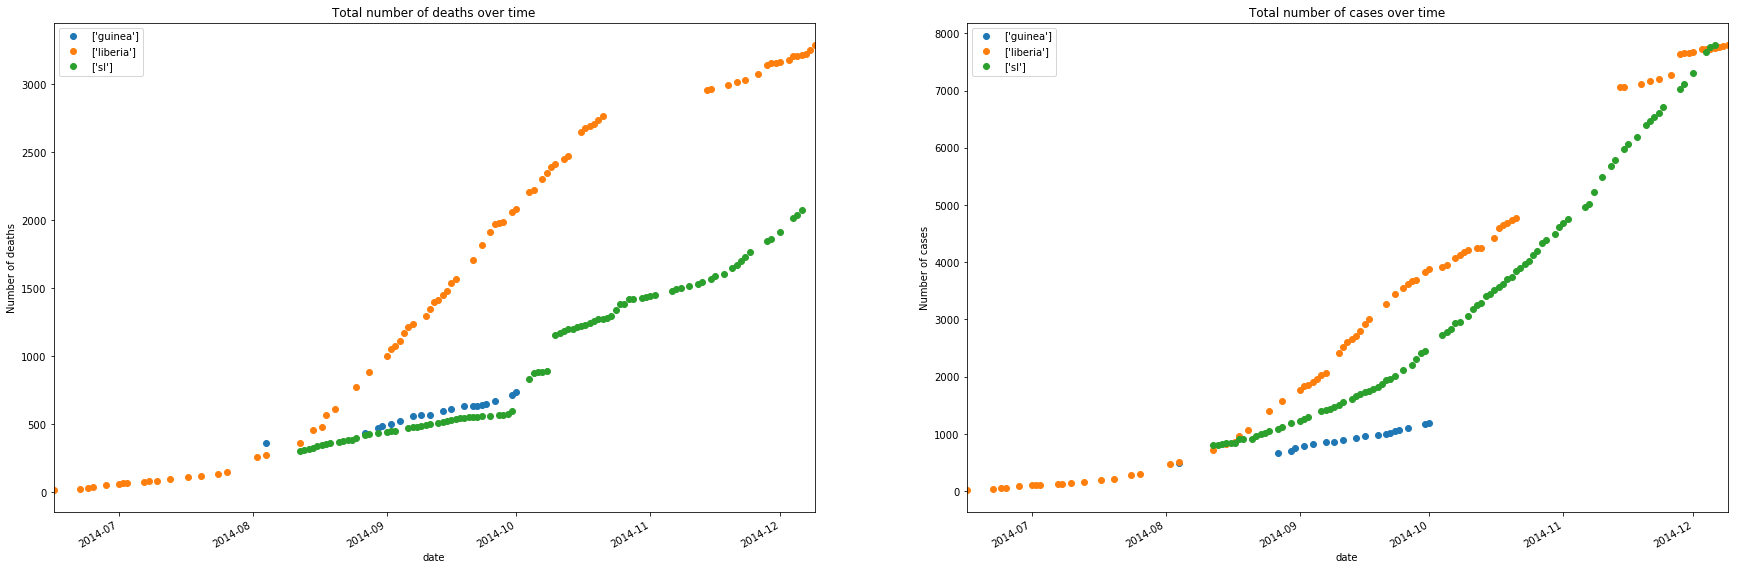

In [9]:
final_ebola_data2 = final_ebola_data[((final_ebola_data.country != 'guinea') | (final_ebola_data.cum_deaths < 800)) & (final_ebola_data.cum_deaths < 4000)]

id_to_remove = []
for country in final_ebola_data2.country:
    min_deaths_value = 0
    min_cases_value = 0
    for index, row in final_ebola_data2[final_ebola_data2.country == country].sort_values('date').iterrows():
        if row['cum_deaths'] > min_deaths_value:
            min_deaths_value = row['cum_deaths']
        else:
            id_to_remove.append(index)
            
        if row['cum_cases'] > min_cases_value:
            min_cases_value = row['cum_cases']
        else:
            id_to_remove.append(index)

final_ebola_data2 = final_ebola_data2.drop(id_to_remove)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

tmp_df = final_ebola_data2.groupby('country')

tmp_df.plot(style='o', x='date', y='cum_deaths', ax=axes[0], legend=True, title='Total number of deaths over time')
axes[0].legend(tmp_df.country.unique())
axes[0].set_ylabel('Number of deaths')

tmp_df.plot(style='o', x='date', y='cum_cases', ax=axes[1], legend=True, title='Total number of cases over time')
axes[1].legend(tmp_df.country.unique())
axes[1].set_ylabel('Number of cases')

tmp_df.describe()

Now we are able to compute the average number of new cases and of new deaths per month for each country. In order to do that, for each month we take the two samples respectively minimizing the time between the beginning/end of the month and the date of the sample. We then apply the formula written at the beginning of the document. We could probably improve our estimation by interpoling the points and taking the predicted value of the total number of deaths/cases at the beginning and at the end of the month, however the purpose of the homework was to learn to import and clean data and not to infer general behavior based on samples.

In [10]:
f_ebola = final_ebola_data2

months = range(final_ebola_data2.date.min().month, final_ebola_data2.date.max().month)

for month in months:
    f_ebola['avg_deaths_%d' % month] = -1
    f_ebola['avg_cases_%d' % month] = -1
    
for country in f_ebola.country.unique():
    c_df = f_ebola[f_ebola.country == country]
    months = range(c_df.date.min().month, c_df.date.max().month)
    print(country)
    for month in months:

        min_day = c_df.date[np.argmin(abs(c_df.date - datetime.date(year = 2014, month = month, day = 1)))]
        max_day = c_df.date[np.argmin(abs(c_df.date - datetime.date(year = 2014, month = month, day = monthrange(2014, month)[1])))]

        min_val = c_df[c_df.date == min_day]
        max_val = c_df[c_df.date == max_day]
        
        avg_deaths = (max_val.cum_deaths.values[0] - min_val.cum_deaths.values[0])/(max_day - min_day).days
        avg_cases = (max_val.cum_cases.values[0] - min_val.cum_cases.values[0])/(max_day - min_day).days
        
        f_ebola.loc[f_ebola.country == country, ['avg_deaths_%d' % month, 'avg_cases_%d' % month]] = \
            [avg_deaths, avg_cases]
        print('\tFor the month of %s average number of deaths is %f and of cases is %f.' % \
              (calendar.month_name[month], avg_deaths, avg_cases))


guinea
	For the month of August average number of deaths is 4.666667 and of cases is 9.407407.
	For the month of September average number of deaths is 7.500000 and of cases is 14.000000.
liberia
	For the month of June average number of deaths is 3.000000 and of cases is 5.200000.
	For the month of July average number of deaths is 6.125000 and of cases is 11.593750.
	For the month of August average number of deaths is 24.900000 and of cases is 43.066667.
	For the month of September average number of deaths is 36.344828 and of cases is 71.137931.
	For the month of October average number of deaths is 34.400000 and of cases is 44.100000.
	For the month of November average number of deaths is 9.675000 and of cases is 72.025000.
sl
	For the month of August average number of deaths is 7.333333 and of cases is 21.666667.
	For the month of September average number of deaths is 5.310345 and of cases is 41.931034.
	For the month of October average number of deaths is 27.000000 and of cases is 69.

### Evaluation of the data set ###

To reach the final code above we needed to evaluate carefully the dataset; here is some sample of code used in this purpose. This code is not really a part of the answer but shows the intermediate steps used.

In this import we also register the number and example of different files which are in the dataset. It is useful to be able to take a look at the data.

In [11]:
folders = ['guinea', 'liberia', 'sl']
folder_end = '_data/'
folder_begin = 'ebola/'

type_of_file = []
name_of_file = []

ebola_data_test = pd.DataFrame(columns=['country', 'town', 'date', 'description', 'number'])
for folder in folders:
    folder_path = DATA_FOLDER + folder_begin + folder + folder_end
    print("Loading data from %s" % folder)
    for data_file in listdir(folder_path):
        if isfile(join(folder_path, data_file)):
            metas = data_file.replace('.', '-').split('-')
            meta_date = datetime.datetime(int(metas[0]), int(metas[1]), int(metas[2]))
            datas = pd.DataFrame.from_csv(folder_path + data_file)
            towns = datas.columns[2:]
            date = datas.index.name
            description = datas.columns[0]
            #register the different type of file it exists.
            if not(list(datas.columns) in type_of_file):
                type_of_file.append(list(datas.columns))
                name_of_file.append(join(folder_path, data_file))
            for town in towns:
                town_data = datas[datas[town] != 0].reset_index().copy()
                town_data['country'] = folder
                town_data['town'] = town
                town_data = town_data[['country', 'town', date, description, town]]
                town_data.columns = ['country', 'town', 'date', 'description', 'number']
                town_data = town_data[(town_data.number.isnull() == False) & (town_data.number != 0)]
                ebola_data_test = pd.concat([ebola_data_test, town_data], axis=0)


Loading data from guinea
Loading data from liberia
Loading data from sl


In [12]:
print(counter)
print(len(type_of_file))

225
24


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

The process is pretty self-explanatory. We create a new DataFrame, load every file in it, then read the last file, merge it on `BARCODE` and replace `NaN` with `unknown`

In [14]:
datas = pd.DataFrame()

for i in range(1, 10):
    file_name = '%s/microbiome/MID%d.xls' % (DATA_FOLDER, i)
    data = pd.read_excel(open(file_name,'rb'), header=None)
    data.columns = ['Subject', 'Value']
    data['BARCODE'] = 'MID%d' % i
    datas = pd.concat([datas, data], axis=0)

data = pd.read_excel(open('%s/microbiome/metadata.xls' % (DATA_FOLDER),'rb'))
datas = datas.merge(data, how='left', on='BARCODE')
datas = datas.fillna('unknown')
datas.set_index(inplace=True, keys=['Subject', 'BARCODE'])

print(datas.index.is_unique)
print(datas.sample(frac=1).head())
datas

True
                                                            Value      GROUP  \
Subject                                            BARCODE                     
Archaea "Crenarchaeota" Thermoprotei Sulfolobal... MID8         1      NEC 2   
Bacteria "Aquificae" Aquificae Aquificales Aqui... MID9        50  Control 2   
Bacteria "Actinobacteria" Actinobacteria Coriob... MID5        35  Control 2   
Bacteria "Proteobacteria" Gammaproteobacteria "... MID2         3      NEC 1   
Bacteria "Proteobacteria" Alphaproteobacteria R... MID4         4      NEC 2   

                                                            SAMPLE  
Subject                                            BARCODE          
Archaea "Crenarchaeota" Thermoprotei Sulfolobal... MID8      stool  
Bacteria "Aquificae" Aquificae Aquificales Aqui... MID9      stool  
Bacteria "Actinobacteria" Actinobacteria Coriob... MID5     tissue  
Bacteria "Proteobacteria" Gammaproteobacteria "... MID2     tissue  
Bacteria "Proteobact

,,Value,GROUP,SAMPLE
Subject,BARCODE,,,
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",MID1,7,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrolobus",MID1,2,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Sulfolobales Sulfolobaceae Stygiolobus",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Thermoproteales Thermofilaceae Thermofilum",MID1,3,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanocellales Methanocellaceae Methanocella",MID1,7,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methanosarcinaceae Methanimicrococcus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Methanosarcinales Methermicoccaceae Methermicoccus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Ferroglobus",MID1,1,EXTRACTION CONTROL,unknown
"Archaea ""Euryarchaeota"" Archaeoglobi Archaeoglobales Archaeoglobaceae Geoglobus",MID1,1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

In [14]:
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [15]:
dataf = pd.read_excel('Data/titanic.xls')


## Question 1

The types of each column can easily be obtained using "dataf.dtypes" as shown in next cell.
We then use the min and max functions on the Series to get the values range. This implies having to make a copy of the DataFrame, as we need to drop the NaN and to convert "object" columns to "string" columns (otherwise, the functions raise an exception).

In [16]:
dataf_cp = dataf.copy()

print('%-15s %-15s %-35s %-35s' % ('Column Name', 'Column Type', 'Column Min', 'Column Max'))
for col in dataf_cp.columns:
    tmp = dataf_cp[col].dropna()
    if dataf_cp[col].dtypes == 'object':
        tmp = tmp.astype(str)
    print('%-15s %-15s %-35s %-35s' % (col, str(dataf_cp[col].dtypes), str(tmp.min()), str(tmp.max())))


Column Name     Column Type     Column Min                          Column Max                         
pclass          int64           1                                   3                                  
survived        int64           0                                   1                                  
name            object          Abbing, Mr. Anthony                 van Melkebeke, Mr. Philemon        
sex             object          female                              male                               
age             float64         0.1667                              80.0                               
sibsp           int64           0                                   8                                  
parch           int64           0                                   9                                  
ticket          object          110152                              WE/P 5735                          
fare            float64         0.0                             

We can change in categorical every column that has a limited number of distinct values (i.e. columns that could be implemented with a dictionary), like: pclass, survived, sex, sibsp, parch, embarked, boat and home.dest.

In [17]:
to_categorical = ['pclass','survived', 'sex', 'sibsp', 'parch', 'embarked', 'boat', 'home.dest']
for c in to_categorical:
    dataf[c] = dataf[c].astype('category')


## Question 2

We use the 'bar' kind of plot, as it is better suited than the 'hist' type for frequencies (as we use value_counts()).
We also use sort_index to have the values in the right order (where it is relevant, for pclass for example).

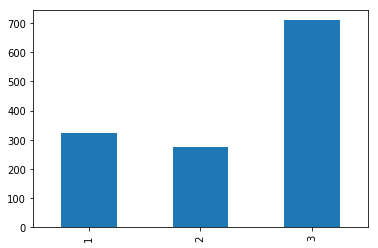

In [18]:
dataf.pclass.value_counts().sort_index().plot(kind='bar')

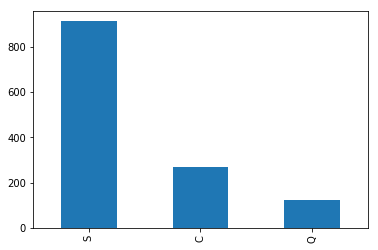

In [19]:
dataf.embarked.value_counts().plot(kind='bar')

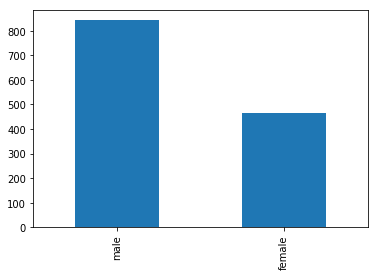

In [20]:
dataf.sex.value_counts().plot(kind='bar')

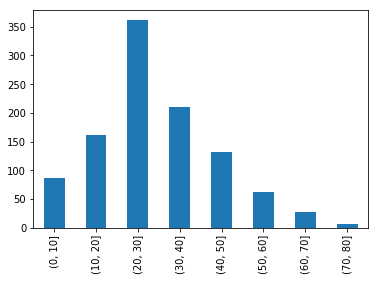

In [21]:
pd.cut(dataf.age, [x for x in range(0, int(dataf.age.max()) + 1, 10)]).value_counts().sort_index().plot(kind='bar')

## Question 3

As the datas are not clear for the cabin column, we arbitrarily picked the first letter of the first cabin that appears in the cell for the floor. For example, for a cabin with cell "C22 D26", we assign the cabin at floor C.

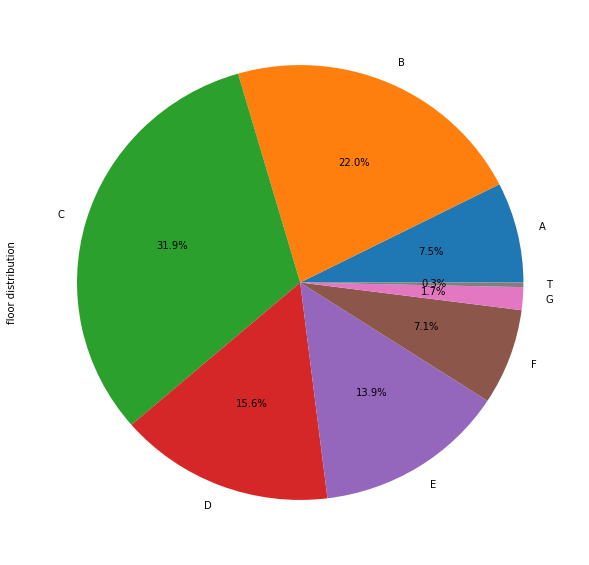

In [22]:
floor = dataf.cabin.copy().dropna().apply(lambda x : x[0]).astype('category').rename('floor distribution')
floor.value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', figsize=(10,10))

## Question 4
We simply use a groupBy on pclass, unstack 'survived', transpose and plot

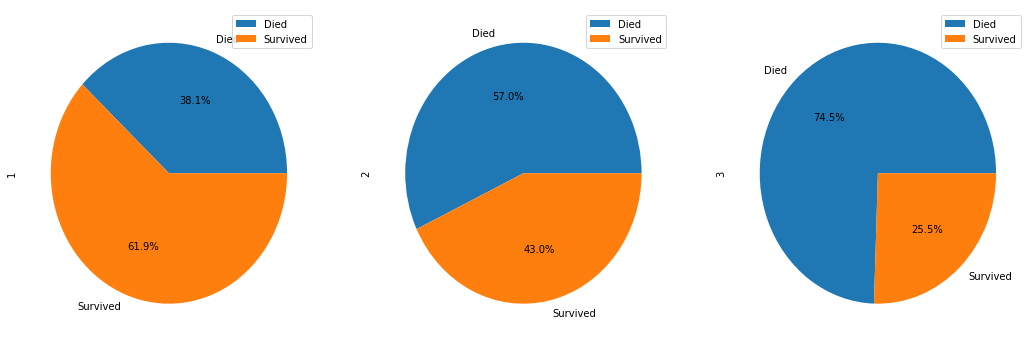

In [24]:
tmp = dataf.groupby(dataf.pclass).survived
ax=tmp.value_counts().unstack('survived').transpose().plot(kind='pie', subplots=True, figsize=(18,6), autopct='%1.1f%%', labels=["Died","Survived"])

## Question 5
We still use the groupBy function on pclass and sex this time, unstack 'survived' and plot using a barplot.

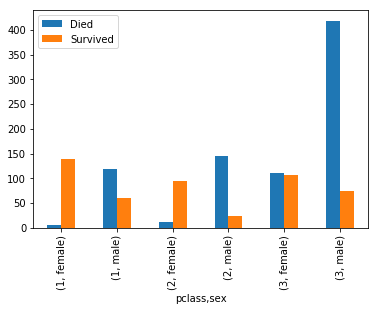

In [26]:
tmp=dataf.groupby([dataf.pclass, dataf.sex]).survived
ax=tmp.value_counts().unstack('survived').plot(kind='bar', legend=False)

patches, labels = ax.get_legend_handles_labels()

ax.legend(patches, ['Died','Survived'], loc='best')

## Question 6
We group by age, class and sex after having cut the age at the median. We then simply unstack 'survived' to create a DataFrame with three hierarchical indices and two columns.

In [27]:
dataf6 = dataf.copy()
dataf6.age=pd.qcut(dataf6.age, 2).dropna()

dataf6.rename(columns={'age':'grouped_age'}, inplace=True)

grouped_index = dataf6.groupby([dataf6.grouped_age, dataf6.pclass, dataf6.sex])
final_data_frame = grouped_index.survived.value_counts().unstack('survived')

final_data_frame.columns = ['dead','survived']
final_data_frame


dead  survived
grouped_age   pclass sex                   
(0.166, 28.0] 1      female     2        39
                     male      15        17
              2      female     5        51
                     male      58        16
              3      female    53        56
                     male     183        41
(28.0, 80.0]  1      female     3        89
                     male      83        36
              2      female     6        41
                     male      77         7
              3      female    27        16
                     male     107        18